
# Advanced Exploratory Data Analysis for Telco Customer Churn

This notebook contains a comprehensive exploratory data analysis (EDA) of the Telco Customer Churn dataset. The goal is to understand the underlying patterns that drive customer churn in a telecommunications company and to generate actionable business insights.



## Introduction

Customer churn refers to the phenomenon of customers leaving a service. Predicting churn helps businesses take proactive steps to retain customers. We will explore the Telco Customer Churn dataset and perform advanced EDA to:

- Assess data quality and understand the target variable distribution.
- Examine the class imbalance problem and its implications.
- Analyze univariate and bivariate distributions to uncover relationships between features and churn.
- Perform multivariate analyses, including correlation analysis and simple customer segmentation.
- Derive business insights that can guide retention strategies.

The dataset includes demographic, service usage, contract, and financial information for over 7,000 customers along with a `Churn` label indicating whether the customer left (`Yes`) or stayed (`No`).


In [1]:

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')

# Set plot aesthetics
sns.set(style="whitegrid")


In [2]:

# Load the dataset
file_path = 'Data/Raw/Raw_Churn_data.csv'
df = pd.read_csv(file_path)

# Display first few rows
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



## 1. Initial Data Assessment

We'll start by inspecting the data types, missing values, and basic statistics to identify any quality issues in the dataset.


In [3]:

# Check data types and basic information
df_info = df.info()

# Identify missing values
df_missing = df.isnull().sum().reset_index()
df_missing.columns = ['feature', 'missing_count']

# Display summary statistics for numeric columns
df_describe = df.describe()

# Show results
print("DataFrame Info:")
print(df_info)

print("Missing Values per Feature:")
print(df_missing[df_missing['missing_count'] > 0])

print("Summary Statistics for Numeric Columns:")
print(df_describe)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:

# Convert TotalCharges to numeric (coerce errors to NaN)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Update missing values after conversion
missing_after_conversion = df.isnull().sum()

# Impute missing TotalCharges values with median
total_median = df['TotalCharges'].median()
df['TotalCharges'].fillna(total_median, inplace=True)

# Display updated missing values
df.isnull().sum()


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


## 1.1 Target Variable Analysis

Understanding the distribution of the target variable `Churn` is essential. We calculate the churn rate, visualize its distribution, and discuss the implications of class imbalance.


Churn Counts: Churn
No     5174
Yes    1869
Name: count, dtype: int64
Churn Ratio: Churn
No     0.73463
Yes    0.26537
Name: count, dtype: float64


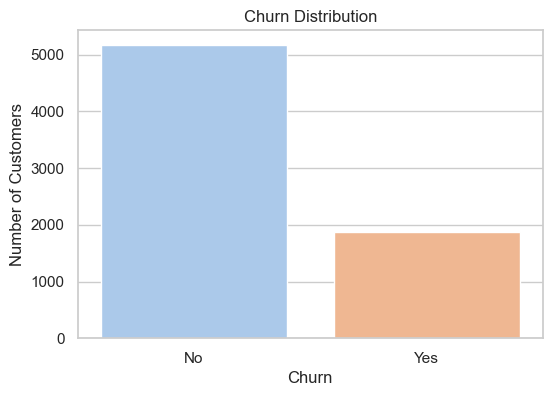

Imbalance Ratio (No/Yes): 2.77


In [8]:

# Compute churn counts and ratios
churn_counts = df['Churn'].value_counts()
churn_ratio = churn_counts / len(df)

print("Churn Counts:", churn_counts)
print("Churn Ratio:", churn_ratio)

# Plot class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df, palette='pastel')
plt.title('Churn Distribution')
plt.ylabel('Number of Customers')
plt.show()

# Calculate imbalance ratio
no_count = churn_counts['No']
yes_count = churn_counts['Yes']
imbalance_ratio = no_count / yes_count
print(f"Imbalance Ratio (No/Yes): {imbalance_ratio:.2f}")



As shown above, the dataset is imbalanced: the majority of customers (`No`) outnumber the churners (`Yes`). A high imbalance ratio suggests that naive models might predict the majority class and still achieve high overall accuracy while failing to correctly identify churners. This motivates the need for appropriate evaluation metrics and resampling techniques when building predictive models.



## 1.2 Feature Overview

The dataset contains three broad categories of features:

- **Demographic Features:** `gender`, `SeniorCitizen`, `Partner`, `Dependents`
- **Service Features:** `PhoneService`, `MultipleLines`, `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`
- **Contract & Billing Features:** `Contract`, `PaperlessBilling`, `PaymentMethod`, `tenure`, `MonthlyCharges`, `TotalCharges`

Understanding these groups helps structure our analysis and informs feature engineering decisions later on.



## 1.3 Class Imbalance Analysis

We further explore the class imbalance by visualizing churn rates across different customer segments. Identifying segments with higher churn rates can reveal patterns that may inform targeted retention strategies.


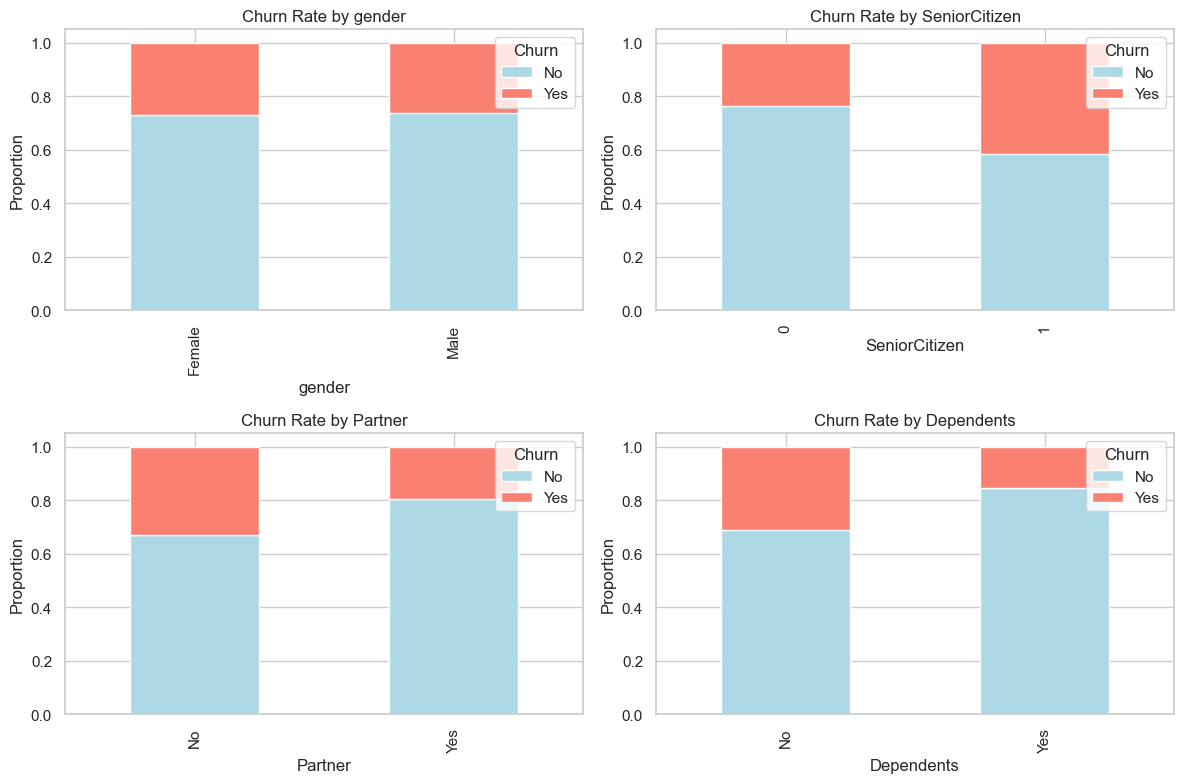

In [9]:

# Plot churn rate by demographic features
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

for i, feature in enumerate(features):
    ax = axes[i//2][i%2]
    churn_rates = pd.crosstab(df[feature], df['Churn'], normalize='index')
    churn_rates.plot(kind='bar', stacked=True, ax=ax, color=['lightblue','salmon'])
    ax.set_title(f'Churn Rate by {feature}')
    ax.set_ylabel('Proportion')
    ax.legend(title='Churn', loc='upper right')

plt.tight_layout()
plt.show()


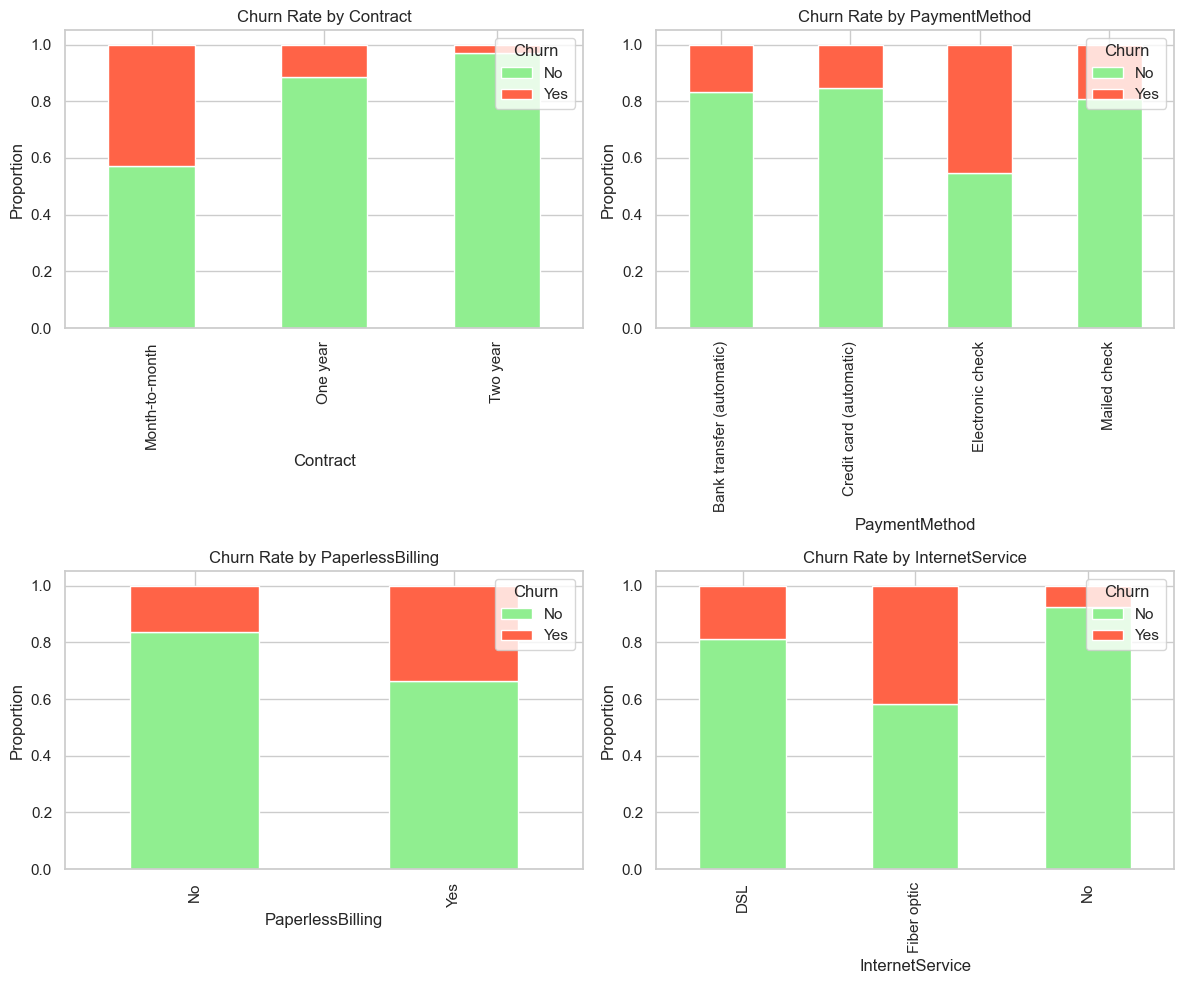

In [10]:

# Plot churn rate by contract/billing features
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
features = ['Contract', 'PaymentMethod', 'PaperlessBilling', 'InternetService']

for i, feature in enumerate(features):
    ax = axes[i//2][i%2]
    churn_rates = pd.crosstab(df[feature], df['Churn'], normalize='index')
    churn_rates.plot(kind='bar', stacked=True, ax=ax, color=['lightgreen','tomato'])
    ax.set_title(f'Churn Rate by {feature}')
    ax.set_ylabel('Proportion')
    ax.legend(title='Churn', loc='upper right')

plt.tight_layout()
plt.show()



From the visualizations above, we observe several patterns:

- **Contract Type:** Customers on month-to-month contracts have a much higher churn rate than those on one-year or two-year contracts.
- **Payment Method:** Electronic check payment is associated with higher churn, whereas automatic bank or credit card payments are linked to lower churn.
- **Paperless Billing:** Customers with paperless billing tend to churn more often.
- **Internet Service:** Customers without internet service churn less (likely because they only purchase phone service), and fiber optic customers show higher churn compared to DSL.

These insights indicate where the business might focus retention efforts.



## 1.4 Advanced Univariate Analysis

We now examine the distribution of numerical features and detect outliers using interquartile range (IQR) and Z-score methods. This helps us understand typical customer behavior and highlight unusual patterns.


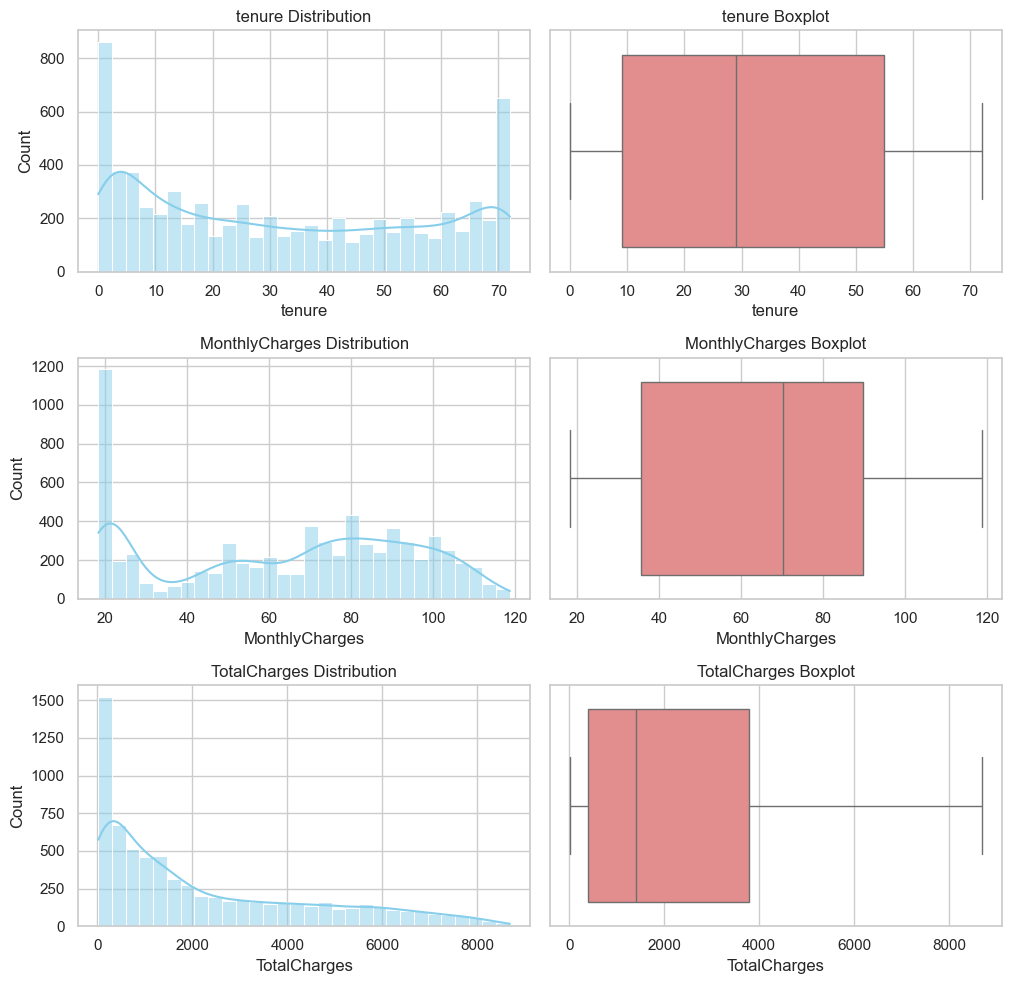

,IQR_outliers,Zscore_outliers
tenure,0,0
MonthlyCharges,0,0
TotalCharges,0,0


In [11]:

# Function to compute outliers using IQR

def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series < lower_bound) | (series > upper_bound)]

# Function to compute outliers using Z-score
from scipy import stats

def detect_outliers_zscore(series, threshold=3):
    z_scores = np.abs(stats.zscore(series))
    return series[(z_scores > threshold)]

numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

outlier_summary = {}
plt.figure(figsize=(15, 10))

for idx, feature in enumerate(numerical_features):
    # Histogram
    plt.subplot(3, 3, idx*3 + 1)
    sns.histplot(df[feature], kde=True, bins=30, color='skyblue')
    plt.title(f'{feature} Distribution')

    # Boxplot
    plt.subplot(3, 3, idx*3 + 2)
    sns.boxplot(x=df[feature], color='lightcoral')
    plt.title(f'{feature} Boxplot')

    # Outlier counts
    iqr_outliers = detect_outliers_iqr(df[feature])
    z_outliers = detect_outliers_zscore(df[feature])
    outlier_summary[feature] = {
        'IQR_outliers': len(iqr_outliers),
        'Zscore_outliers': len(z_outliers)
    }

plt.tight_layout()
plt.show()

# Display outlier summary
pd.DataFrame(outlier_summary).T



The numerical features are skewed. `MonthlyCharges` and `TotalCharges` show right-skewed distributions, while `tenure` has more uniform distribution with peaks at certain tenure durations. Outlier counts are relatively small, indicating that the majority of customers fall within reasonable ranges. Skewness and outliers should be handled carefully when building predictive models.



### Categorical Feature Analysis and Relationship with Churn

We analyze how categorical features distribute among the customer base and how they relate to churn. Understanding these relationships may reveal key churn drivers.


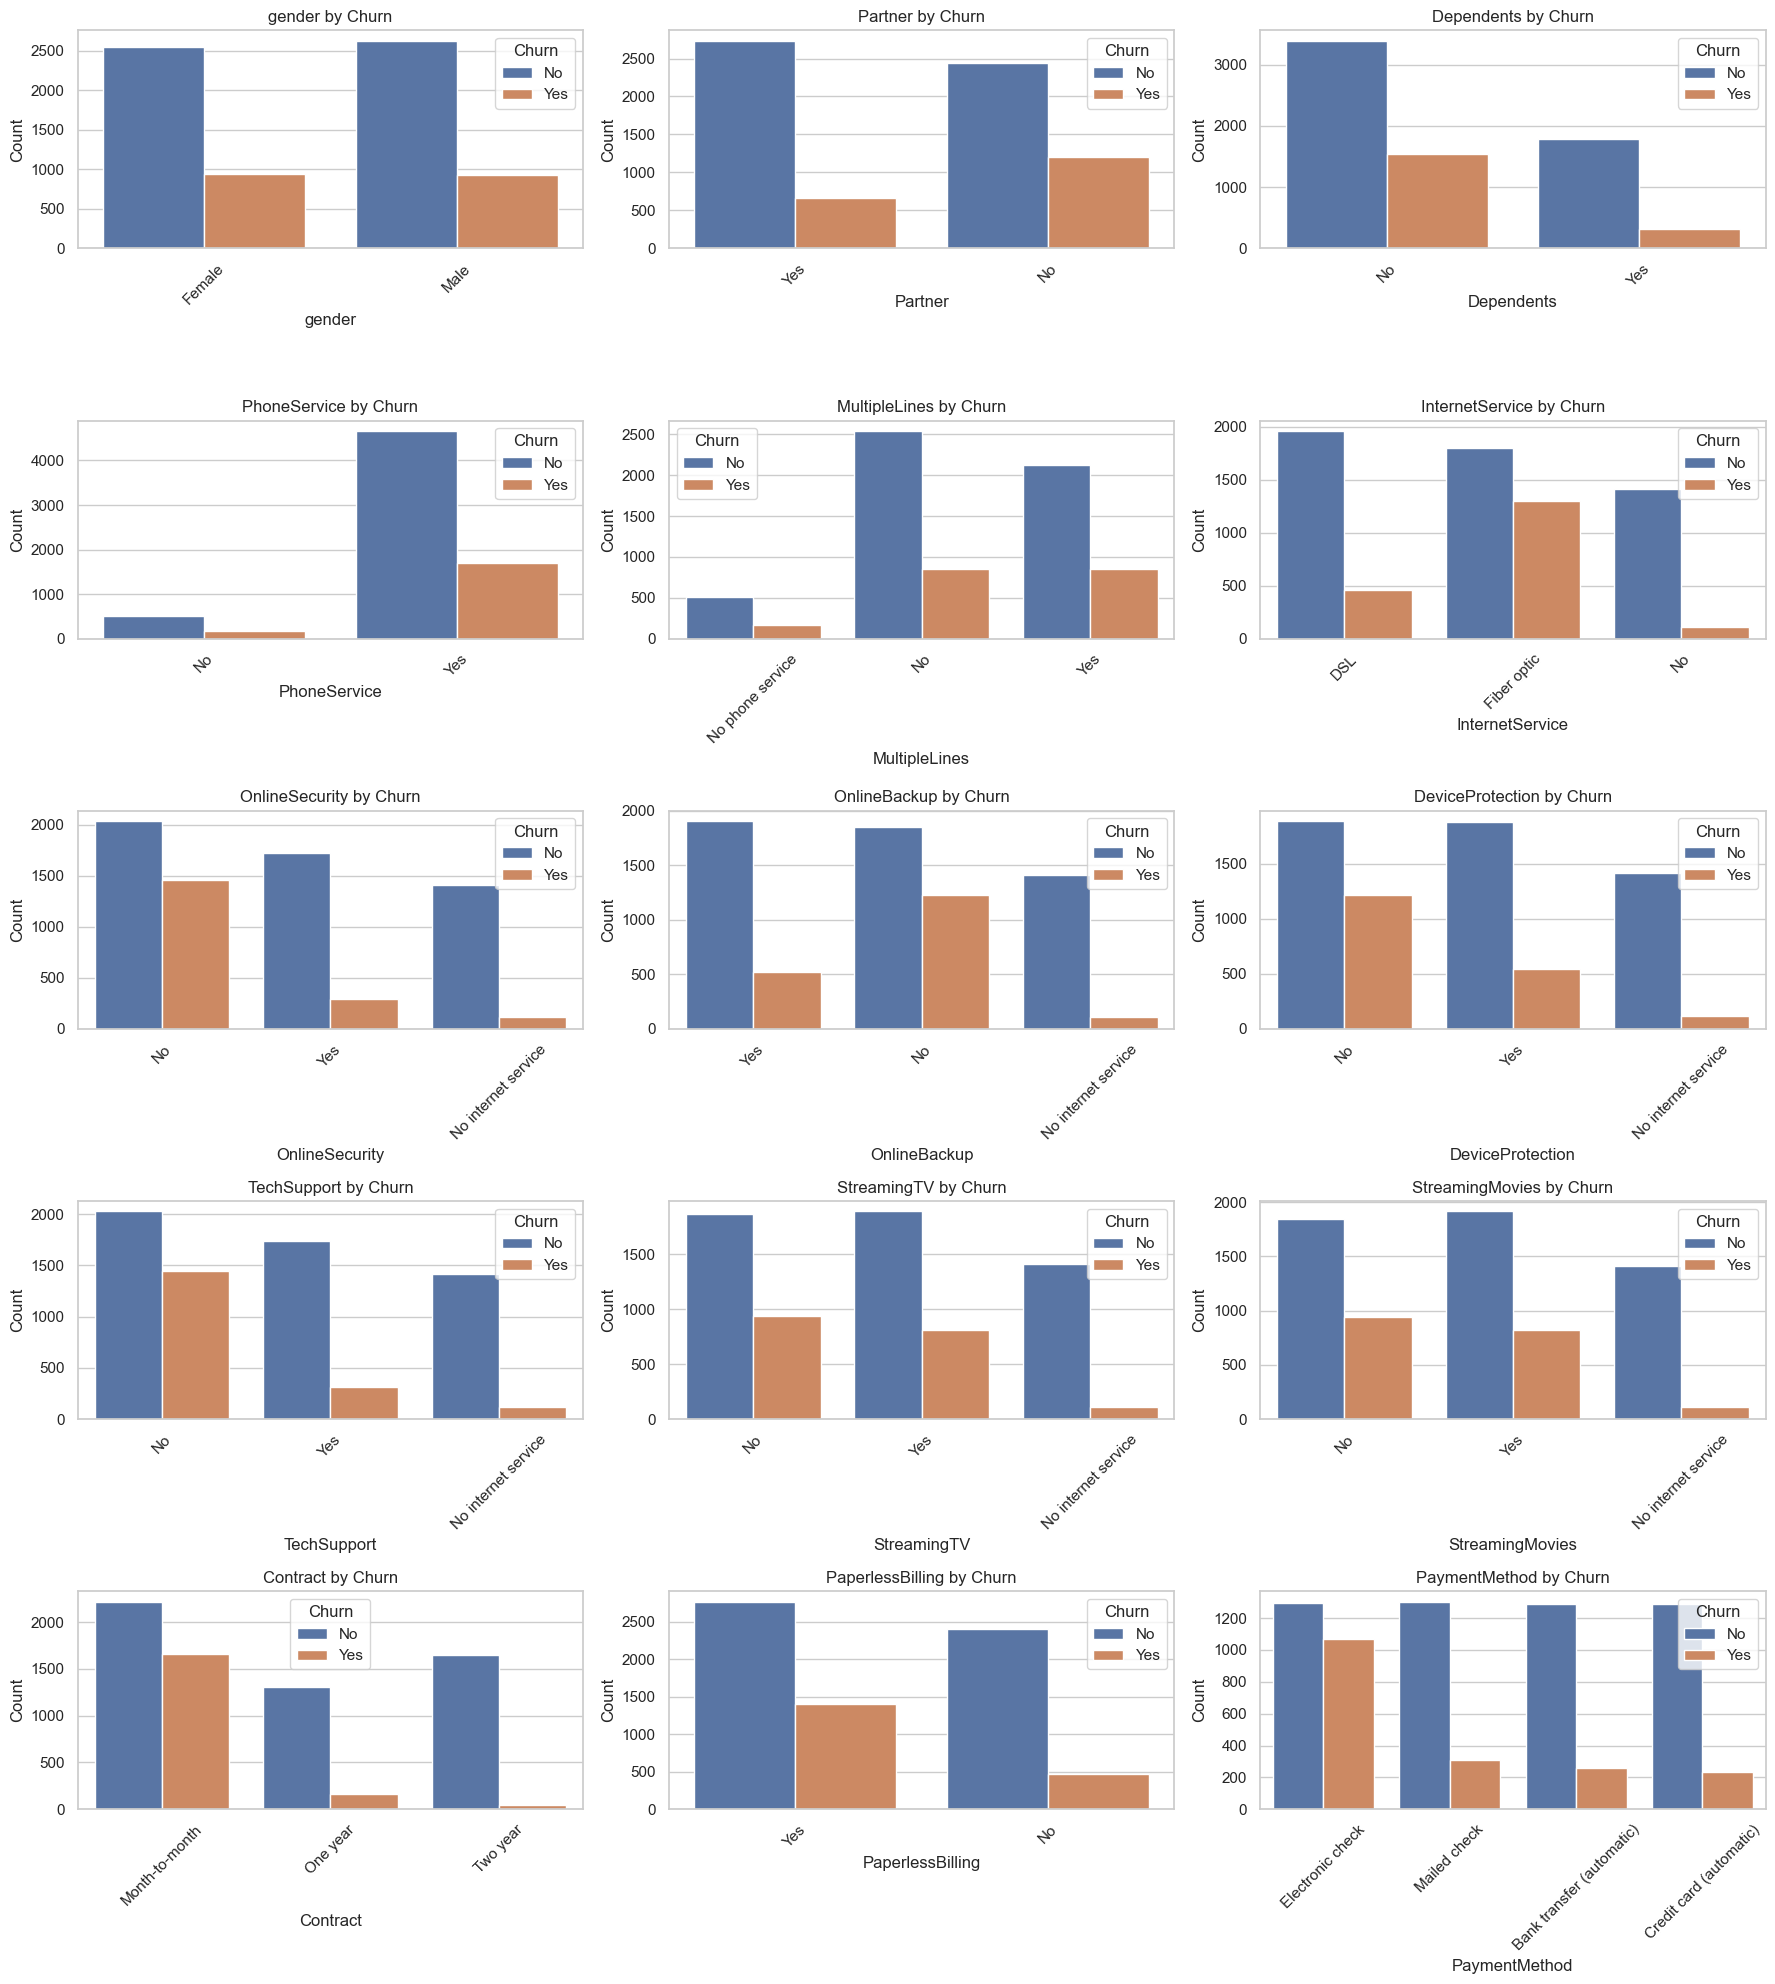

In [12]:

# Select categorical columns (excluding target)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('customerID')
categorical_cols.remove('Churn')

# Plot count plots for each categorical variable
num_cols = 3
num_rows = int(np.ceil(len(categorical_cols) / num_cols))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 4 * num_rows))

for i, col in enumerate(categorical_cols):
    ax = axes[i//num_cols][i%num_cols]
    sns.countplot(x=col, data=df, hue='Churn', ax=ax)
    ax.set_title(f'{col} by Churn')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

# Remove empty subplots
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes[j//num_cols][j%num_cols])

plt.tight_layout()
plt.show()



Many service-related categorical features (e.g., `OnlineSecurity`, `TechSupport`, `StreamingTV`) exhibit a clear relationship with churn. Customers who do **not** subscribe to security or tech-support services tend to churn more frequently, suggesting that bundling these services could improve retention. Conversely, customers subscribed to additional services often exhibit lower churn rates.



### Feature Engineering Opportunities

Based on the univariate analysis, several derived features could be created to enhance model performance:

- **Tenure Categories:** Group `tenure` into categories (e.g., New: 0–12 months, Established: 13–48 months, Loyal: > 48 months) to capture lifecycle stages.
- **Service Count:** Count the number of optional services a customer subscribes to (e.g., security, backup, streaming) as an indicator of engagement.
- **Average Charge per Service:** Compute `MonthlyCharges` divided by the number of subscribed services to account for package pricing.
- **Payment Reliability:** Flag customers paying electronically (which is associated with higher churn) versus those using automatic payments.

We will implement these features in later stages when building predictive models.



## 1.5 Comprehensive Bivariate Analysis

To validate the relationships observed above, we perform statistical tests:

- **Chi-Square tests** for categorical features vs. `Churn` to test for independence.
- **t-tests** for numeric features vs. `Churn` to assess mean differences between churners and non-churners.

We also visualize these relationships using boxplots and bar charts.


In [13]:

from scipy.stats import chi2_contingency, ttest_ind

# Chi-square tests for selected categorical features
cat_features_to_test = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                        'PhoneService', 'MultipleLines', 'InternetService',
                        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                        'TechSupport', 'StreamingTV', 'StreamingMovies',
                        'Contract', 'PaperlessBilling', 'PaymentMethod']

chi2_results = []
for feature in cat_features_to_test:
    contingency = pd.crosstab(df[feature], df['Churn'])
    chi2, p, dof, ex = chi2_contingency(contingency)
    chi2_results.append({'feature': feature, 'chi2': chi2, 'p_value': p})

chi2_df = pd.DataFrame(chi2_results).sort_values('p_value')

# t-tests for numeric features
num_features_to_test = ['tenure', 'MonthlyCharges', 'TotalCharges']
ttest_results = []
for feature in num_features_to_test:
    churn_yes = df[df['Churn']=='Yes'][feature]
    churn_no = df[df['Churn']=='No'][feature]
    t_stat, p_val = ttest_ind(churn_yes, churn_no, equal_var=False)
    ttest_results.append({'feature': feature, 't_stat': t_stat, 'p_value': p_val})

p_values_df = pd.DataFrame(ttest_results).sort_values('p_value')

# Display results
print("Chi-Square Test Results (top 10 by smallest p-values):")
print(chi2_df.head(10))

print("T-Test Results for Numeric Features:")
print(p_values_df)


Chi-Square Test Results (top 10 by smallest p-values):
             feature         chi2        p_value
13          Contract  1184.596572  5.863038e-258
7     OnlineSecurity   849.998968  2.661150e-185
10       TechSupport   828.197068  1.443084e-180
6    InternetService   732.309590  9.571788e-160
15     PaymentMethod   648.142327  3.682355e-140
8       OnlineBackup   601.812790  2.079759e-131
9   DeviceProtection   558.419369  5.505219e-122
12   StreamingMovies   375.661479   2.667757e-82
11       StreamingTV   374.203943   5.528994e-82
14  PaperlessBilling   258.277649   4.073355e-58
T-Test Results for Numeric Features:
          feature     t_stat        p_value
0          tenure -34.823819  1.195495e-232
2    TotalCharges -18.767951   2.059075e-75
1  MonthlyCharges  18.407527   8.592449e-73


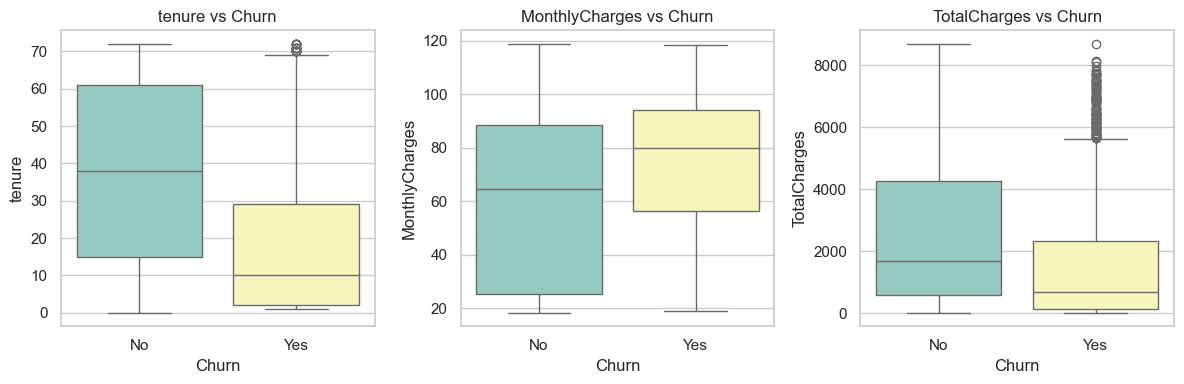

In [14]:

# Boxplots for numeric features vs churn
plt.figure(figsize=(12, 4))
for i, feature in enumerate(num_features_to_test):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='Churn', y=feature, data=df, palette='Set3')
    plt.title(f'{feature} vs Churn')

plt.tight_layout()
plt.show()



**Interpretation**:

- Most categorical features have extremely low p-values in the chi-square tests, indicating strong associations with churn. Features like `Contract`, `PaymentMethod`, `TechSupport`, and `InternetService` show particularly significant relationships.
- The t-tests for numerical features reveal significant mean differences between churners and non-churners for `tenure`, `MonthlyCharges`, and `TotalCharges` (p-values \< 0.05). Churners tend to have shorter tenure, higher monthly charges, and lower total charges, consistent with the idea that newer customers paying more are at higher risk.



## 1.6 Multivariate Analysis

We analyze correlations among numerical features and explore interactions between categorical variables to identify multicollinearity and complex relationships.


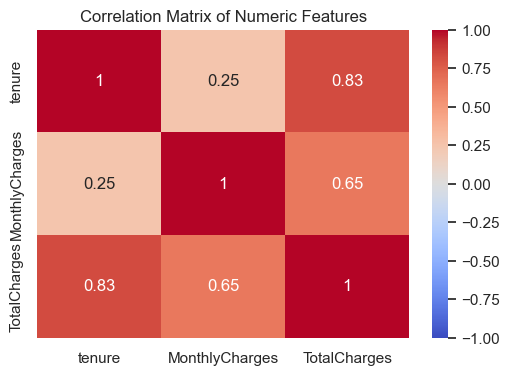

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.247900,0.825464
MonthlyCharges,0.247900,1.000000,0.650864
TotalCharges,0.825464,0.650864,1.000000


In [15]:

# Correlation matrix for numerical features
corr = df[['tenure','MonthlyCharges','TotalCharges']].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

corr


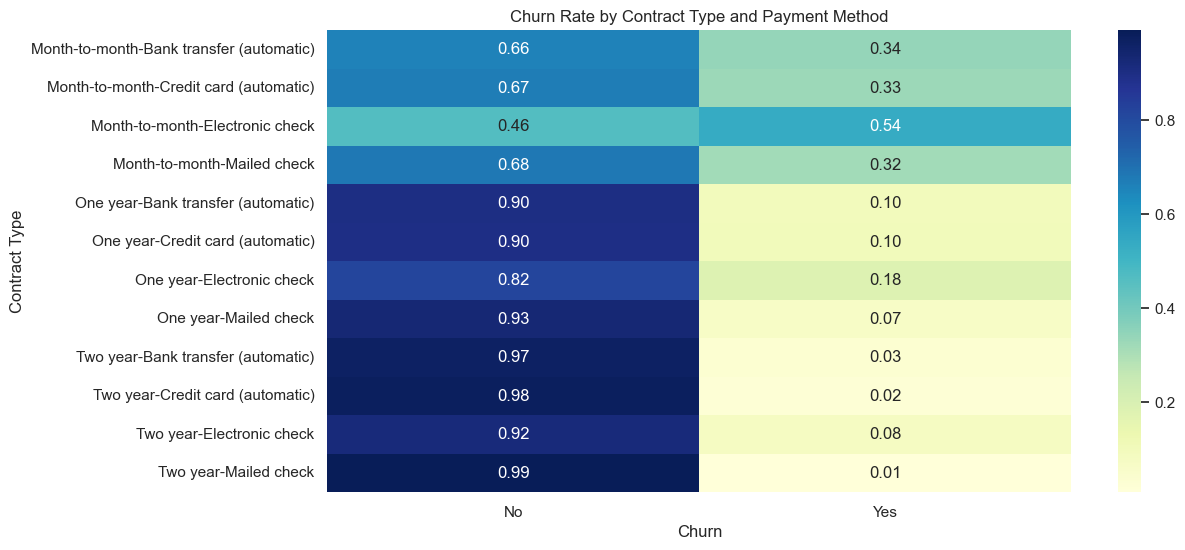

Churn                                           No       Yes
Contract       PaymentMethod                                
Month-to-month Bank transfer (automatic)  0.658744  0.341256
               Credit card (automatic)    0.672192  0.327808
               Electronic check           0.462703  0.537297
               Mailed check               0.684211  0.315789
One year       Bank transfer (automatic)  0.902813  0.097187
               Credit card (automatic)    0.896985  0.103015
               Electronic check           0.815562  0.184438
               Mailed check               0.931751  0.068249
Two year       Bank transfer (automatic)  0.966312  0.033688
               Credit card (automatic)    0.977625  0.022375
               Electronic check           0.922619  0.077381
               Mailed check               0.992147  0.007853

In [16]:

# Interaction example: Contract and PaymentMethod
interaction_counts = df.groupby(['Contract','PaymentMethod'])['Churn'].value_counts(normalize=True).unstack().fillna(0)

plt.figure(figsize=(12,6))
sns.heatmap(interaction_counts, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Churn Rate by Contract Type and Payment Method')
plt.ylabel('Contract Type')
plt.xlabel('Churn')
plt.show()

interaction_counts



The correlation matrix shows that `MonthlyCharges` and `TotalCharges` have a strong positive correlation, as expected since total charges accumulate monthly charges over time. `Tenure` is moderately correlated with `TotalCharges` but almost independent of `MonthlyCharges`. The interaction heatmap highlights how payment method and contract type jointly influence churn: month-to-month customers paying via electronic check exhibit the highest churn rates.



### Customer Segmentation Using K-Means

To gain additional insights, we perform a simple segmentation of customers based on tenure and charges. Clustering helps reveal distinct groups that may require different retention strategies. We standardize the numeric variables and run K-Means clustering into three clusters, then examine the churn rate and average characteristics of each cluster.


In [ ]:

# Prepare data for clustering
cluster_features = df[['tenure','MonthlyCharges','TotalCharges']]
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_features)

# Run KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(cluster_scaled)

df['Cluster'] = clusters

# Examine cluster characteristics
cluster_summary = df.groupby('Cluster').agg({
    'tenure': 'mean',
    'MonthlyCharges': 'mean',
    'TotalCharges': 'mean',
    'Churn': lambda x: (x == 'Yes').mean()
}).rename(columns={'Churn': 'ChurnRate'})

cluster_summary



The segmentation reveals distinct customer groups:

- **Cluster 0:** Customers with very short tenure and low total charges but moderate monthly charges show the highest churn rate. They are likely new customers who have not yet established loyalty.
- **Cluster 1:** Long-tenure customers with high total charges and lower monthly charges have the lowest churn rate. These loyal customers may be on longer-term contracts and benefit from discounts.
- **Cluster 2:** Mid-tenure customers with relatively high monthly and total charges exhibit intermediate churn rates.

These clusters can guide tailored retention strategies, such as onboarding improvements for new customers (Cluster 0) and loyalty rewards for long-standing customers (Cluster 1).



## 1.7 Business Insights

Based on the analyses above, we derive the following insights:

1. **High-Risk Profiles:**
   - Customers on month-to-month contracts paying via electronic check are at the highest risk of churn.
   - New customers (low tenure) paying high monthly charges and subscribing to few value-added services have elevated churn rates.
   - Senior citizens with no partners or dependents and minimal optional services tend to churn more.

2. **Retention Opportunities:**
   - Encourage customers to switch from month-to-month to longer-term contracts by offering incentives or discounts.
   - Promote automatic payment methods (e.g., bank or credit card drafts) which are associated with lower churn.
   - Bundle security and tech-support services to increase engagement and reduce churn.
   - Implement targeted onboarding programs for new customers to improve their initial experience and satisfaction.

3. **Revenue Impact:**
   - The average monthly charge for churners is \$74.44, and their average tenure is 17.98 months.
   - Assuming churners leave at the end of their observed tenure, the company potentially loses **\$1,497,916.35** in future revenue if no retention actions are taken (assuming a 24‑month customer lifetime value horizon).
